In [1]:
import os
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: /workspace/iscat


In [2]:
from src.data_processing.dataset import iScatDataset
from src.data_processing.utils import Utils
import torch
DEVICE= 'cuda:12' if torch.cuda.is_available() else 'cpu'
data_path = os.path.join('dataset', '2024_11_11', 'Metasurface', 'Chip_02')
image_paths,target_paths = Utils.get_data_paths(data_path)

In [3]:
image_size=256
fluo_masks_indices=[1]
seg_method = "comdet"
train_dataset = iScatDataset(image_paths[:-1], target_paths[:-1], preload_image=True,image_size = (image_size,image_size),apply_augmentation=True,normalize=False,device=DEVICE,fluo_masks_indices=fluo_masks_indices,seg_method=seg_method)
valid_dataset = iScatDataset([image_paths[-1]],[target_paths[-1]],preload_image=True,image_size = (image_size,image_size),apply_augmentation=False,normalize=False,device=DEVICE,fluo_masks_indices=fluo_masks_indices,seg_method=seg_method)

Loading TIFF images to Memory: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.80it/s]


In [4]:
from torch.utils.data import DataLoader, Dataset
def create_dataloaders(train_dataset, test_dataset, batch_size=4):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader
train_loader, val_loader = create_dataloaders(train_dataset, valid_dataset, batch_size=4)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from monai.losses import DiceLoss
from monai.metrics import MeanIoU
import numpy as np
from monai.networks.utils import one_hot

def z_score_normalize(images: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    Normalize a batch of images using z-score normalization.

    Args:
        images (torch.Tensor): Input tensor of shape (N, 3, H, W), where
                               N is the batch size, 3 is the number of channels,
                               H and W are height and width.
        eps (float): A small value to avoid division by zero (default: 1e-8).

    Returns:
        torch.Tensor: Z-score normalized tensor of the same shape as `images`.
    """
    normalized_images = images/65535.0
    # Compute mean and std for each image in the batch
    mean = normalized_images .mean(dim=(1, 2, 3), keepdim=True)  # Shape: (N, 1, 1, 1)
    std = normalized_images .std(dim=(1, 2, 3), keepdim=True)    # Shape: (N, 1, 1, 1)
    
    # Perform z-score normalization
    normalized_images = (normalized_images - mean) / (std + eps)
    return normalized_images
    
def calculate_class_weights_from_masks(masks):

    class_counts = torch.zeros(2, dtype=torch.float)

    flattened_masks = masks.view(-1)  # Combine N, H, W into a single dimension

    unique, counts = torch.unique(flattened_masks.cpu(), return_counts=True)

    for label, count in zip(unique, counts):
        label = int(label)  # Ensure label is an integer
        class_counts[label] += count

    total_pixels = class_counts.sum()
    class_weights = total_pixels / (2 * class_counts)  # 2 is number of classes

    class_weights = class_weights / class_weights.sum()
    
    return class_weights

 
class MultiClassUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, init_features=32):
        super(MultiClassUNet, self).__init__()
        
        # Load the pretrained model and modify the final layer
        model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
                               in_channels=in_channels, 
                               out_channels=1, 
                               init_features=init_features, 
                               pretrained=False)
        
        # Replace the final convolution layer to match number of classes
        model.conv = nn.Conv2d(init_features, num_classes, kernel_size=1)
        
        self.model = model
    
    def forward(self, x):
        return self.model(x)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from monai.losses import DiceLoss,DiceCELoss
from monai.metrics import MeanIoU
import numpy as np
from enum import Enum
from typing import Dict, Any
from monai.networks.utils import one_hot

class LossType(Enum):
    CROSSENTROPY = "crossentropy"
    DICE = "dice"
    COMBINED = "combined"

class UNetTrainer:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        loss_type: LossType,
        class_weights: None,
        learning_rate: float = 1e-4,
        log_dir: str = "runs/unet_training"
    ):
        self.num_class=2
        self.model = model.to(device)
        self.device = device
        self.loss_type = loss_type
        self.class_weights=class_weights
        # Initialize loss functions
        
       
        if self.num_class ==1:
            self.ce_loss = nn.BCEWithLogitsLoss()
            self.dice_loss = DiceLoss(
                sigmoid=True,
                squared_pred=True,  # Changed to False for potentially better stability
                batch=True,
                reduction="mean"
            )
        else:
            self.ce_loss = nn.CrossEntropyLoss(
                label_smoothing=0.1,
                weight=self.class_weights        
            )      
            self.dice_loss = DiceLoss(
                softmax=True,
                squared_pred=True,  # Changed to False for potentially better stability
                batch=True,
                reduction="mean"
            )  
            self.ce_dice_loss = DiceCELoss(
                softmax=True,
                squared_pred=True,  # Changed to False for potentially better stability
                batch=True,
                reduction="mean",
                weight=self.class_weights,
            )  
                
        # Initialize metrics
        self.miou_metric = MeanIoU(include_background=True, reduction="mean")
        
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Add learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.1,
            patience=5,
            verbose=True
        )
        self.writer = SummaryWriter(log_dir)

    def compute_loss(self, predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Compute the specified loss
        predictions: (batch_size, 1, height, width)
        targets: (batch_size, height, width)
        """
        # Add channel dimension to targets if needed
        if len(targets.shape) == 3:
            targets = targets.unsqueeze(1)
            if self.num_class==2:
                targets=one_hot(targets,num_classes=2)
            
        # Ensure targets are float
        targets = targets.float()
        
        if self.loss_type == LossType.CROSSENTROPY:
            return self.ce_loss(predictions, targets)
        elif self.loss_type == LossType.DICE:
            return self.dice_loss(predictions, targets)
        # else:  # COMBINED
        #     ce = self.ce_loss(predictions, targets)
        #     dice = self.dice_loss(predictions, targets)
        #     return ce + dice
        else:
            return self.ce_dice_loss(predictions,targets)
            
    def compute_metrics(self, predictions: torch.Tensor, targets: torch.Tensor) -> float:
        """
        Compute mean IoU metric
        predictions: (batch_size, 1, height, width)
        targets: (batch_size, height, width)
        """
        # Ensure predictions are binary
        if self.num_class==2:
            pred_masks = (torch.softmax(predictions,dim=1) > 0.5).float()
        else:
            pred_mask = (torch.sigmoid(predictions) > 0.5).float()
        # Add channel dimension to targets if needed
        if len(targets.shape) == 3:
            targets = targets.unsqueeze(1)
        
        # Convert predictions and targets to one-hot format (required by MeanIoU)
        # Shape: (batch_size, 2, height, width)
        if self.num_class==1:
            pred_one_hot = torch.cat([1 - pred_masks, pred_masks], dim=1)
        else:
            pred_one_hot=pred_masks
        target_one_hot = torch.cat([1 - targets, targets], dim=1)
        
        # Compute IoU
        metric = self.miou_metric(pred_one_hot, target_one_hot)
        
        # Return mean IoU (average across classes)
        return metric.nanmean().item()

    def train_epoch(self, train_loader, epoch: int) -> Dict[str, float]:
        self.model.train()
        total_loss = 0.0
        total_miou = 0.0
        batches = 0

        for batch_idx, (images, masks) in enumerate(train_loader):
            # Move data to device and normalize images
            images = z_score_normalize(images).to(self.device)
            masks = masks.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            predictions = self.model(images)  # Shape: (batch_size, 1, height, width)
            
            # Compute loss and backpropagate
            loss = self.compute_loss(predictions, masks)
            loss.backward()
            
            
            self.optimizer.step()
            
            # Compute metrics
            miou = self.compute_metrics(predictions, masks)
            
            # Update running statistics
            total_loss += loss.item()
            total_miou += miou
            batches += 1
            
            # Log to TensorBoard
            step = epoch * len(train_loader) + batch_idx
            self.writer.add_scalar('Train/Loss', loss.item(), step)
            self.writer.add_scalar('Train/mIoU', miou, step)
            
            # Print batch progress
            if batch_idx % 10 == 0:
                print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}, mIoU: {miou:.4f}')

        return {
            'loss': total_loss / batches,
            'miou': total_miou / batches
        }

    @torch.no_grad()
    def validate(self, val_loader) -> Dict[str, float]:
        self.model.eval()
        total_loss = 0.0
        total_miou = 0.0
        batches = 0

        for images, masks in val_loader:
            images = z_score_normalize(images).to(self.device)
            masks = masks.to(self.device)
            
            predictions = self.model(images)
            loss = self.compute_loss(predictions, masks)
            miou = self.compute_metrics(predictions, masks)
            
            total_loss += loss.item()
            total_miou += miou
            batches += 1

        return {
            'val_loss': total_loss / batches,
            'val_miou': total_miou / batches
        }

    def train(self, train_loader, val_loader, num_epochs: int):
            best_val_miou = 0.0
            patience = 100 # Early stopping patience
            no_improve = 0
            
            for epoch in range(num_epochs):
                # Training phase
                train_metrics = self.train_epoch(train_loader, epoch)
                
                # Validation phase
                val_metrics = self.validate(val_loader)
                
                # Update learning rate scheduler
                self.scheduler.step(val_metrics['val_loss'])
                
                # Log validation metrics
                self.writer.add_scalar('Validation/Loss', val_metrics['val_loss'], epoch)
                self.writer.add_scalar('Validation/mIoU', val_metrics['val_miou'], epoch)
                
                # Save best model
                if val_metrics['val_miou'] > best_val_miou:
                    best_val_miou = val_metrics['val_miou']
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'val_miou': val_metrics['val_miou'],
                    }, 'best_model.pth')
                    no_improve = 0
                else:
                    no_improve += 1
                
                # Early stopping
                if no_improve >= patience:
                    print(f'Early stopping triggered after {patience} epochs without improvement')
                    break
                
                print(f"Epoch {epoch+1}/{num_epochs}")
                print(f"Train Loss: {train_metrics['loss']:.4f}, Train mIoU: {train_metrics['miou']:.4f}")
                print(f"Val Loss: {val_metrics['val_loss']:.4f}, Val mIoU: {val_metrics['val_miou']:.4f}")
                print(f"Learning rate: {self.optimizer.param_groups[0]['lr']:.2e}")
                print("-" * 50)


In [23]:
class_weights=calculate_class_weights_from_masks(train_dataset.masks).to(DEVICE)
# Initialize model
model = MultiClassUNet(in_channels=3, num_classes=2, init_features=64)

# Initialize trainer
trainer = UNetTrainer(
    model=model,
    device=DEVICE,
    loss_type=LossType.COMBINED, 
    class_weights=class_weights,# or CROSSENTROPY or DICE
    learning_rate=1e-4
)

trainer.train(train_loader, val_loader, num_epochs=100)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Batch 0/100, Loss: 0.4982, mIoU: 0.2737
Batch 10/100, Loss: 0.4961, mIoU: 0.3470
Batch 20/100, Loss: 0.4953, mIoU: 0.4044
Batch 30/100, Loss: 0.4973, mIoU: 0.4537
Batch 40/100, Loss: 0.4923, mIoU: 0.5067
Batch 50/100, Loss: 0.4964, mIoU: 0.5094
Batch 60/100, Loss: 0.4934, mIoU: 0.5311
Batch 70/100, Loss: 0.4919, mIoU: 0.5336
Batch 80/100, Loss: 0.4919, mIoU: 0.5439
Batch 90/100, Loss: 0.4939, mIoU: 0.5313
Epoch 1/100
Train Loss: 0.4949, Train mIoU: 0.4785
Val Loss: 0.4920, Val mIoU: 0.4991
Learning rate: 1.00e-04
--------------------------------------------------
Batch 0/100, Loss: 0.4952, mIoU: 0.5363
Batch 10/100, Loss: 0.4918, mIoU: 0.5556
Batch 20/100, Loss: 0.4916, mIoU: 0.5545
Batch 30/100, Loss: 0.4938, mIoU: 0.5437
Batch 40/100, Loss: 0.4933, mIoU: 0.5823
Batch 50/100, Loss: 0.4893, mIoU: 0.5669
Batch 60/100, Loss: 0.4939, mIoU: 0.5628
Batch 70/100, Loss: 0.4962, mIoU: 0.5535
Batch 80/100, Loss: 0.4912, mIoU: 0.6088
Batch 90/100, Loss: 0.4896, mIoU: 0.6216
Epoch 2/100
Train Los

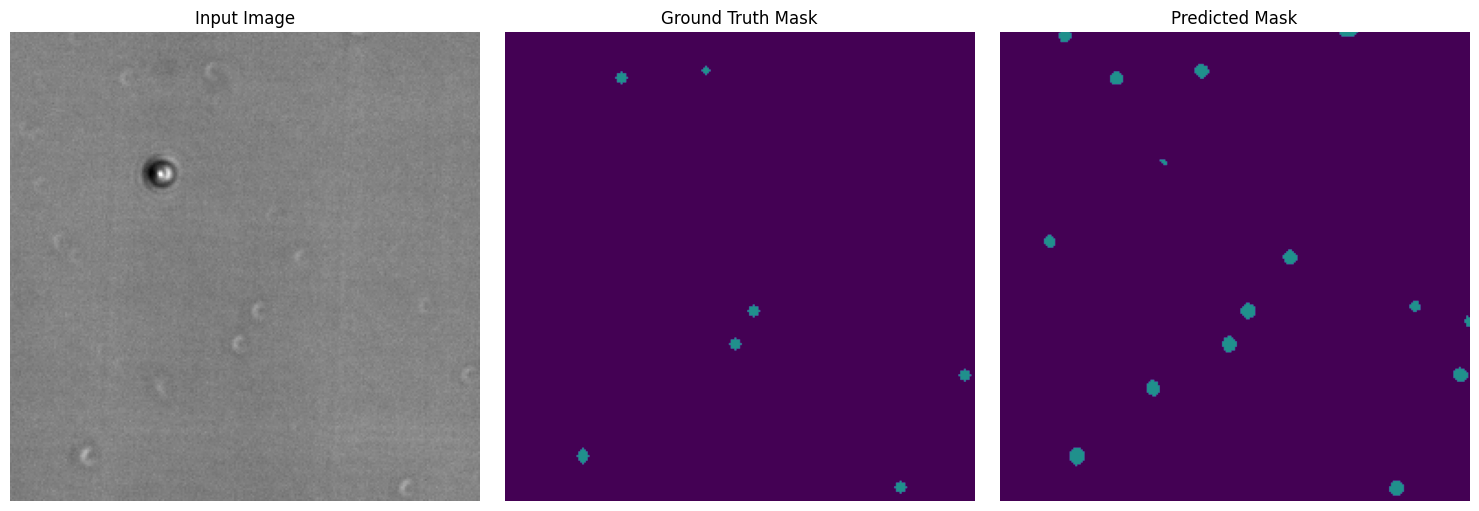

In [25]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_sample_prediction(model, dataset, device, idx=0, num_classes=3):
    """
    Plots the predicted mask and ground truth for a sample from the dataset.
    
    Args:
        model: Trained segmentation model.
        dataset: Validation dataset.
        device: Device (CPU or GPU).
        idx: Index of the sample to visualize.
        num_classes: Number of classes in the segmentation task.
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Get a sample image and its ground truth mask
    image, mask = dataset[idx]  # (image: torch.Size([3, 224, 224]), mask: torch.Size([3, 224, 224]))
    
    # Add batch dimension to the image
    image = image.unsqueeze(0).to(device)  # torch.Size([1, 3, 224, 224])
    input_image = z_score_normalize(image)
    # Ground truth mask
    ground_truth_mask = mask.cpu().numpy()  # Shape: (224, 224)

    # Get the model's predicted mask
    with torch.no_grad():
        output = model(input_image)  # Shape: [1, num_classes, 224, 224]
        predicted_mask = torch.argmax(output.squeeze(0), dim=0).cpu().numpy()  # Shape: (224, 224)
    
    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    image = image.squeeze(0).cpu().numpy()
    axes[0].imshow(image[2],cmap='gray')  
    axes[0].set_title("Input Image")
    axes[0].axis("off")
    axes[1].imshow(ground_truth_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")
    
    axes[2].imshow(predicted_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()
    return image,predicted_mask,ground_truth_mask
# Example Usage
# Assuming model, valid_dataset, and device are already defined
image,predicted_mask,ground_truth_mask = plot_sample_prediction(model, valid_dataset, DEVICE,3)

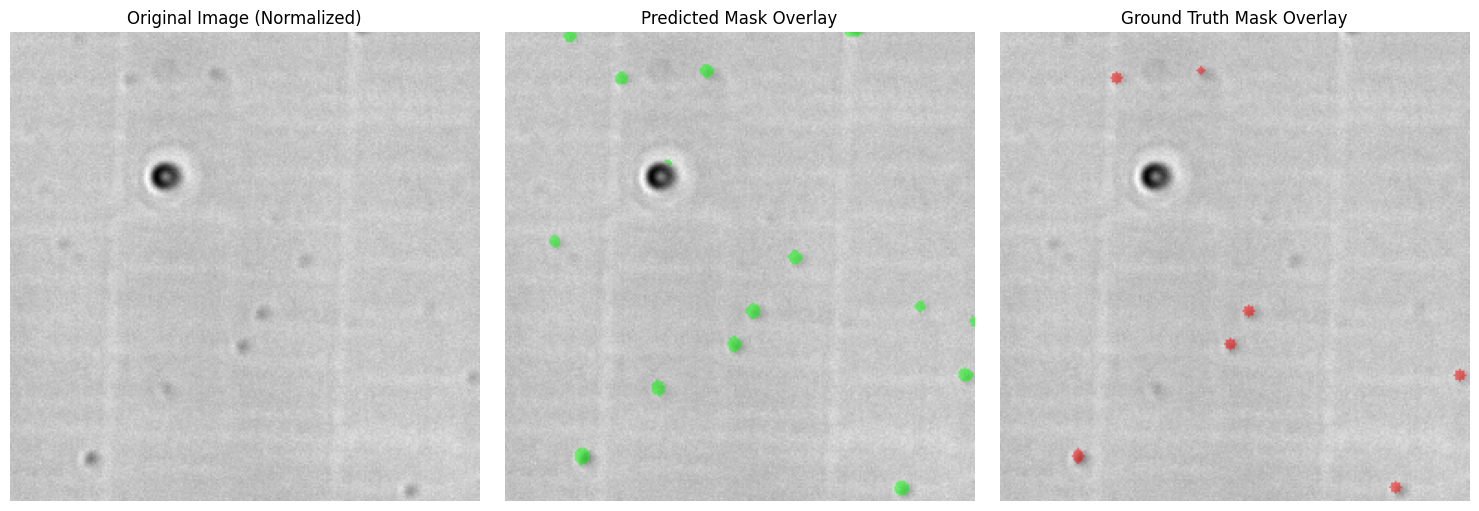

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def normalize_image(image):
    """
    Normalize a 16-bit grayscale image to 8-bit for visualization.

    Parameters:
        image (ndarray): 16-bit grayscale image.

    Returns:
        ndarray: 8-bit grayscale image.
    """
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
    return (image * 255).astype(np.uint8)  # Scale to [0, 255]

def overlay_mask(image, mask, color, alpha=0.5):
    """
    Overlays a mask on an image with a specified color and transparency.

    Parameters:
        image (ndarray): Original image (H, W) for grayscale or (H, W, 3) for RGB.
        mask (ndarray): Binary mask (H, W).
        color (tuple): Color for the mask (R, G, B).
        alpha (float): Transparency for the overlay.

    Returns:
        ndarray: Image with mask overlay.
    """
    if len(image.shape) == 2:  # Grayscale image
        overlay = np.stack([image] * 3, axis=-1)  # Convert to RGB
    else:  # RGB image
        overlay = image.copy()

    for c in range(3):  # Apply the mask color
        overlay[:, :, c] = np.where(mask, 
                                    overlay[:, :, c] * (1 - alpha) + color[c] * alpha, 
                                    overlay[:, :, c])
    return overlay

def plot_image_with_masks(image, predicted_mask, ground_truth_mask, output_path="output.png"):
    # Normalize the 16-bit grayscale image to 8-bit
    image_normalized = normalize_image(image)

    # Ensure masks are boolean
    predicted_mask = predicted_mask.astype(bool)
    ground_truth_mask = ground_truth_mask.astype(bool)

    # Overlay masks with distinct colors
    predicted_overlay = overlay_mask(image_normalized, predicted_mask, color=(0, 255, 0), alpha=0.5)  # Green
    gt_overlay = overlay_mask(image_normalized, ground_truth_mask, color=(255, 0, 0), alpha=0.5)  # Red

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image_normalized, cmap='gray')
    axs[0].set_title("Original Image (Normalized)")
    axs[0].axis("off")

    axs[1].imshow(predicted_overlay)
    axs[1].set_title("Predicted Mask Overlay")
    axs[1].axis("off")

    axs[2].imshow(gt_overlay)
    axs[2].set_title("Ground Truth Mask Overlay")
    axs[2].axis("off")

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight') 
    plt.show()



plot_image_with_masks(image[0], predicted_mask, ground_truth_mask, output_path="plot_with_masks_5.png")
